In [42]:
#importing all relevant liabraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

import plotly.express as px
import hvplot.pandas

In [43]:
# Read Csv
data = pd.read_csv("../Data/sales_order_sheet_processed.csv", sep=",", encoding="ISO-8859-1", header=0)
data

,ordernumber,sales_channel,warehousecode,procureddate,orderdate,shipdate,deliverydate,currencycode,salesteamid,customerid,storeid,productid,order_quantity,discount_applied,unit_price,unit_cost,order_total,order_discount,grand_total
0,SO - 000101,In-Store,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-14,2018-06-19,USD,6,15,259,12,5,0.075,1963.1,1001.181,9815.5,736.1625,9079.3375
1,SO - 000102,Online,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-22,2018-07-02,USD,14,20,196,27,3,0.075,3939.6,3348.660,11818.8,886.4100,10932.3900
2,SO - 000103,Distributor,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-21,2018-07-01,USD,21,16,213,16,1,0.050,1775.5,781.220,1775.5,88.7750,1686.7250
3,SO - 000104,Wholesale,WARE-NMK1003,2017-12-31,2018-05-31,2018-06-02,2018-06-07,USD,28,48,107,23,8,0.075,2324.9,1464.687,18599.2,1394.9400,17204.2600
4,SO - 000105,Distributor,WARE-NMK1003,2018-04-10,2018-05-31,2018-06-16,2018-06-26,USD,22,49,111,26,8,0.100,1822.4,1476.144,14579.2,1457.9200,13121.2800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7986,SO - 0008087,In-Store,WARE-MKL1006,2020-09-26,2020-12-30,2021-01-07,2021-01-14,USD,9,41,339,29,1,0.075,234.5,121.940,234.5,17.5875,216.9125
7987,SO - 0008088,Online,WARE-NMK1003,2020-09-26,2020-12-30,2021-01-02,2021-01-04,USD,14,29,202,3,6,0.050,3202.6,1921.560,19215.6,960.7800,18254.8200
7988,SO - 0008089,Online,WARE-UHY1004,2020-09-26,2020-12-30,2021-01-23,2021-01-26,USD,14,32,241,35,5,0.200,3825.7,2792.761,19128.5,3825.7000,15302.8000
7989,SO - 0008090,Online,WARE-NMK1003,2020-09-26,2020-12-30,2021-01-20,2021-01-25,USD,20,42,112,36,8,0.100,1072.0,804.000,8576.0,857.6000,7718.4000


In [44]:
# Find the null values
data.isnull().sum()

ordernumber         0
sales_channel       0
warehousecode       0
procureddate        0
orderdate           0
shipdate            0
deliverydate        0
currencycode        0
salesteamid         0
customerid          0
storeid             0
productid           0
order_quantity      0
discount_applied    0
unit_price          0
unit_cost           0
order_total         0
order_discount      0
grand_total         0
dtype: int64

In [45]:
# find duplicate from entries
print (f"Duplicate entries :{data.duplicated().sum()}")

Duplicate entries :0


In [46]:
revenue_contributed = data.groupby('customerid')['order_total'].sum()
revenue_contributed = revenue_contributed.reset_index()
revenue_contributed.head()

,customerid,order_total
0,1,1322278.5
1,2,1346264.5
2,3,1831947.5
3,4,1770582.2
4,5,1609232.8


In [47]:
frequency = data.groupby('customerid')['orderdate'].count()
frequency = frequency.reset_index()
frequency.head()

,customerid,orderdate
0,1,152
1,2,135
2,3,181
3,4,167
4,5,159


In [48]:
# convert the data duration in days 
data['orderdate'] = pd.to_datetime(data['orderdate'], format='%Y-%m-%d %H:%M')
data['duration'] = data['orderdate'].max() - data['orderdate']
data['duration']

0      944 days
1      944 days
2      944 days
3      944 days
4      944 days
         ...   
7986     0 days
7987     0 days
7988     0 days
7989     0 days
7990     0 days
Name: duration, Length: 7991, dtype: timedelta64[ns]

In [49]:
# Group by customerid and duration min 
recency = data.groupby('customerid')['duration'].min()
recency = recency.reset_index()
recency.head()

,customerid,duration
0,1,7 days
1,2,7 days
2,3,8 days
3,4,3 days
4,5,28 days


In [50]:
#merging data
rf = pd.merge(revenue_contributed, frequency, on='customerid', how='inner')
rfm = pd.merge(rf, recency, on='customerid', how='inner')
rfm.columns = ['customerid', 'order_total', 'frequency', 'recency']
rfm['recency'] = rfm['recency'].dt.days
rfm.head()

,customerid,order_total,frequency,recency
0,1,1322278.5,152,7
1,2,1346264.5,135,7
2,3,1831947.5,181,8
3,4,1770582.2,167,3
4,5,1609232.8,159,28


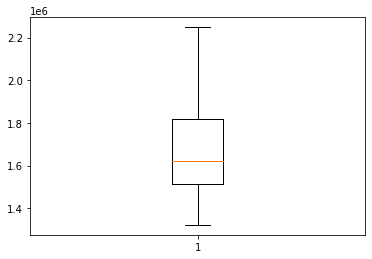

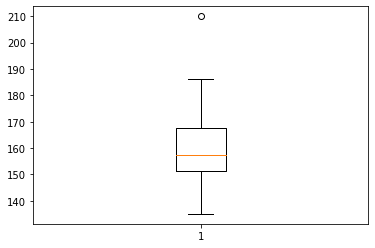

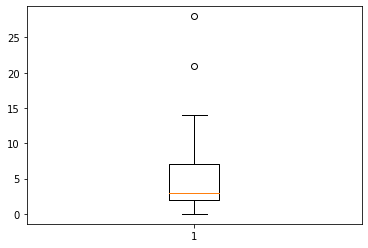

In [51]:
# Box plots
plt.boxplot(rfm['order_total'])
plt.show()
plt.boxplot(rfm['frequency'])
plt.show()
plt.boxplot(rfm['recency'])
plt.show()

## inertia

In [52]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(rfm)
    inertia.append(km.inertia_)

In [53]:
inertia

[1971708377855.7292,
 567503375521.5507,
 351107972345.5323,
 166846629810.4687,
 95394242280.20978,
 61146265512.20546,
 47139208414.53371,
 38294662492.52459,
 25495731934.9211,
 19514900372.92704]

In [54]:
elbow_data = {"k": k, "inertia" : inertia }
elbow_data

{'k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'inertia': [1971708377855.7292,
  567503375521.5507,
  351107972345.5323,
  166846629810.4687,
  95394242280.20978,
  61146265512.20546,
  47139208414.53371,
  38294662492.52459,
  25495731934.9211,
  19514900372.92704]}

In [55]:
df_elbow =pd.DataFrame(elbow_data)
df_elbow

,k,inertia
0,1,1.971708e+12
1,2,5.675034e+11
2,3,3.511080e+11
3,4,1.668466e+11
4,5,9.539424e+10
5,6,6.114627e+10
6,7,4.713921e+10
7,8,3.829466e+10
8,9,2.549573e+10
9,10,1.951490e+10


In [56]:
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

### Looking at the Elbow curve, the vertical direction shifts to a strong horizontal direction hapening between 4 and 5 and 6. So, we will try with K= 4, 5 and 6. 
 

In [57]:
# create def get_cluster
def get_clusters(k, data):
    # Create a copy of the DataFrame
    data = data.copy()

    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Fit the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [58]:
# Four Clusters
four_clusters =get_clusters(4,rfm)
four_clusters.head(10)

,customerid,order_total,frequency,recency,class
0,1,1322278.5,152,7,0
1,2,1346264.5,135,7,0
2,3,1831947.5,181,8,1
3,4,1770582.2,167,3,1
4,5,1609232.8,159,28,2
5,6,1530755.7,143,2,2
6,7,1544061.9,153,1,2
7,8,1411522.5,142,3,0
8,9,1830038.0,171,6,1
9,10,1763942.5,158,13,1


In [59]:
# Four scatter plot
four_clusters.hvplot.scatter(x="order_total",y="frequency",by="class")

:NdOverlay   [class]
   :Scatter   [order_total]   (frequency)

In [60]:
# Plot a 3D graph for K = 4:
# Plot the 3D-scatter with x="order_total", y="frequency" and z="recency"
fig = px.scatter_3d(
    four_clusters,
    x="order_total",
    y="frequency",
    z="recency",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


In [61]:
# Five Clusters
five_clusters =get_clusters(5,rfm)
five_clusters.head(10)

,customerid,order_total,frequency,recency,class
0,1,1322278.5,152,7,4
1,2,1346264.5,135,7,4
2,3,1831947.5,181,8,0
3,4,1770582.2,167,3,0
4,5,1609232.8,159,28,2
5,6,1530755.7,143,2,1
6,7,1544061.9,153,1,1
7,8,1411522.5,142,3,4
8,9,1830038.0,171,6,0
9,10,1763942.5,158,13,0


In [62]:
# Six clusters
six_clusters =get_clusters(6,rfm)
six_clusters.head(10)

,customerid,order_total,frequency,recency,class
0,1,1322278.5,152,7,4
1,2,1346264.5,135,7,4
2,3,1831947.5,181,8,1
3,4,1770582.2,167,3,5
4,5,1609232.8,159,28,3
5,6,1530755.7,143,2,0
6,7,1544061.9,153,1,0
7,8,1411522.5,142,3,4
8,9,1830038.0,171,6,1
9,10,1763942.5,158,13,5


In [63]:
# five scatter plot
five_clusters.hvplot.scatter(x="order_total",y="frequency",by="class")

:NdOverlay   [class]
   :Scatter   [order_total]   (frequency)

In [64]:
six_clusters.hvplot.scatter(x="order_total",y="recency",by="class")

:NdOverlay   [class]
   :Scatter   [order_total]   (recency)

In [65]:
# Plot a 3D graph for K = 5:
# Plot the 3D-scatter with x="order_total", y="frequency" and z="recency"
fig = px.scatter_3d(
    five_clusters,
    x="order_total",
    y="frequency",
    z="recency",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


In [66]:
six_clusters.hvplot.scatter(x="order_total",y="frequency",by="class")

:NdOverlay   [class]
   :Scatter   [order_total]   (frequency)

In [67]:
six_clusters.hvplot.scatter(x="order_total",y="recency",by="class")

:NdOverlay   [class]
   :Scatter   [order_total]   (recency)

In [68]:
# Plot a 3D graph for K = 6:
# Plot the 3D-scatter with x="order_total", y="frequency" and z="recency"
fig = px.scatter_3d(
    six_clusters,
    x="order_total",
    y="frequency",
    z="recency",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()